In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler

train_data = pd.read_csv("daan881_group4_dataset.train.csv")

train_data.head()

,cve,attack_vector,attack_complexity,attack_requirements,privileges_required,user_interaction,exploit_maturity,epss,percentile,cvss_score,cvss_severity,days_since_reserved,days_since_published,date_reserved_published_delta,priority_score,group_id
0,CVE-2021-43778,1.0,0.0,NaN,2.0,0.0,NaN,0.52469,0.97623,9.1,1.0,1123,1114,9,50.680890,1
1,CVE-2023-37231,1.0,0.0,NaN,2.0,0.0,NaN,0.00045,0.16337,9.8,1.0,533,94,439,14.572191,1
2,CVE-2021-21856,1.0,0.0,NaN,2.0,1.0,NaN,0.00307,0.70126,8.8,2.0,1439,1212,227,13.354978,1
3,CVE-2021-23855,1.0,0.0,NaN,2.0,0.0,NaN,0.00168,0.54167,8.6,2.0,1431,1165,266,13.138801,1
4,CVE-2022-27178,3.0,0.0,NaN,2.0,0.0,NaN,0.00283,0.68918,9.6,1.0,996,860,136,13.047501,1


In [62]:
features = [
    "attack_vector",
    "attack_complexity",
    "attack_requirements",
    "privileges_required",
    "user_interaction",
    "exploit_maturity",
    "epss",
    "percentile",
    "cvss_score",
    "cvss_severity",
    "days_since_published",
    "date_reserved_published_delta"
]
X = train_data[features]
y = train_data["priority_score"]
groups = train_data["group_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_train = groups.iloc[train_idx]
    groups_test = groups.iloc[test_idx]

# Verify group integrity
print("Train Groups:", groups_train.unique())
print("Test Groups:", groups_test.unique())

Train Groups: [   1    2    3    4    5    6    7    8    9   10   12   13   14   15
   16   17   18   19   20   21   22   23   25   27   28   29   30   32
   33   34   35   36   37   38   39   41   42   43   44   46   47   48
   49   50   51   52   53   54   57   58   59   62   63   65   66   69
   70   72   74   75   76   78   80   81   82   83   84   85   86   88
   90   91   92   93   94   95   96   98   99  100  101  103  104  105
  106  107  109  110  112  113  114  115  116  117  118  119  120  122
  123  124  125  126  127  128  129  130  131  132  133  134  135  136
  139  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  160  161  162  163  164  165  166  167  168
  170  171  172  173  174  176  177  178  179  180  181  182  183  184
  186  187  188  189  190  191  192  193  194  195  196  197  198  201
  202  203  204  205  206  207  208  212  213  215  217  218  220  221
  223  224  225  226  227  228  229  230  231  232  233  234  2

In [63]:
# Calculate group sizes for training and testing
train_group_sizes = groups_train.value_counts(sort=False).values
test_group_sizes = groups_test.value_counts(sort=False).values

scaler = MinMaxScaler(feature_range=(0, 31))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten().astype(int)
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten().astype(int)

# Create DMatrix for XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train_scaled)
test_dmatrix = xgb.DMatrix(X_test, label=y_test_scaled)

# Set group sizes
train_dmatrix.set_group(train_group_sizes)
test_dmatrix.set_group(test_group_sizes)

# Define XGBoost parameters
params = {
    "objective": "rank:pairwise",  # Pairwise ranking
    "eval_metric": ["rmse","ndcg"],       # Normalized Discounted Cumulative Gain
    "learning_rate": 0.1,
    "max_depth": 6,
    "n_estimators": 100,
    "random_state": 42
}

evals_result = {}

# Train the model
ranker = xgb.train(
    params,
    train_dmatrix,
    num_boost_round=100,
    evals=[(train_dmatrix, "train"), (test_dmatrix, "test")],
    verbose_eval=10,
    evals_result=evals_result
)

[0]	train-rmse:2.74308	train-ndcg:0.81160	test-rmse:2.84782	test-ndcg:0.80785


c:\Users\clayt\Documents\gradschoold\ai881\project\daan881\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-rmse:2.98404	train-ndcg:0.89325	test-rmse:3.07389	test-ndcg:0.86480
[20]	train-rmse:3.26277	train-ndcg:0.92037	test-rmse:3.34017	test-ndcg:0.89384
[30]	train-rmse:3.56530	train-ndcg:0.92835	test-rmse:3.63183	test-ndcg:0.89583
[40]	train-rmse:3.88805	train-ndcg:0.93483	test-rmse:3.94525	test-ndcg:0.90829
[50]	train-rmse:4.21814	train-ndcg:0.93877	test-rmse:4.26752	test-ndcg:0.91084
[60]	train-rmse:4.55149	train-ndcg:0.94737	test-rmse:4.59390	test-ndcg:0.92350
[70]	train-rmse:4.88698	train-ndcg:0.94942	test-rmse:4.92360	test-ndcg:0.92269
[80]	train-rmse:5.22627	train-ndcg:0.95084	test-rmse:5.25801	test-ndcg:0.92134
[90]	train-rmse:5.56186	train-ndcg:0.95155	test-rmse:5.58961	test-ndcg:0.92150
[99]	train-rmse:5.86538	train-ndcg:0.95258	test-rmse:5.88973	test-ndcg:0.92736


In [64]:
# Predict rankings for test data
y_pred = ranker.predict(test_dmatrix)

# Evaluate using NDCG score
ndcg = ndcg_score([y_test], [y_pred])
print("NDCG Score:", ndcg)

# Rank the CVEs in the test set based on predictions
X_test['predicted_priority'] = y_pred
X_test['true_priority'] = y_test
ranked_cves = X_test.sort_values(by='predicted_priority', ascending=False)

# Output ranked CVEs
print(ranked_cves)

NDCG Score: 0.9979133085415954
        attack_vector  attack_complexity  attack_requirements  \
236958            1.0                0.0                  NaN   
127360            1.0                0.0                  NaN   
260106            1.0                0.0                  NaN   
260105            1.0                0.0                  NaN   
295508            1.0                0.0                  NaN   
...               ...                ...                  ...   
301861            NaN                NaN                  NaN   
301860            NaN                NaN                  NaN   
301859            NaN                NaN                  NaN   
301857            NaN                NaN                  NaN   
301853            NaN                NaN                  NaN   

        privileges_required  user_interaction  exploit_maturity     epss  \
236958                  2.0               1.0               NaN  0.80818   
127360                  2.0         

C:\Users\clayt\AppData\Local\Temp\ipykernel_15612\292277252.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predicted_priority'] = y_pred
C:\Users\clayt\AppData\Local\Temp\ipykernel_15612\292277252.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['true_priority'] = y_test


In [65]:
# Evaluate NDCG for training and test sets
train_predictions = ranker.predict(train_dmatrix)
test_predictions = ranker.predict(test_dmatrix)

train_ndcg = ndcg_score([y_train_scaled], [train_predictions])
test_ndcg = ndcg_score([y_test_scaled], [test_predictions])

print(f"Train NDCG: {train_ndcg}")
print(f"Test NDCG: {test_ndcg}")

Train NDCG: 0.9977445173425934
Test NDCG: 0.9966664380359374


In [66]:
def mean_reciprocal_rank(y_true, y_pred, groups):
    """
    Calculate Mean Reciprocal Rank (MRR) for grouped data.
    
    Parameters:
    - y_true: Array of true relevance scores for all items.
    - y_pred: Array of predicted scores for all items.
    - groups: List of group sizes (number of items in each group).

    Returns:
    - MRR: Mean Reciprocal Rank score.
    """
    mrr = []
    start = 0

    for group_size in groups:
        # Slice the true and predicted values for the current group
        end = start + group_size
        true_group = y_true[start:end]
        pred_group = y_pred[start:end]

        # Get the sorted indices of predictions for the group
        sorted_indices = np.argsort(-pred_group)

        # Find the rank of the most relevant item
        for rank, idx in enumerate(sorted_indices, start=1):
            if true_group[idx] == max(true_group):  # Check for the most relevant item
                mrr.append(1 / rank)
                break

        start = end  # Move to the next group

    # Return the mean of reciprocal ranks across all groups
    return np.mean(mrr)

test_group_sizes = groups_test.value_counts(sort=False).tolist()

scaler = MinMaxScaler(feature_range=(0, 31))
test_predictions = scaler.fit_transform(test_predictions.reshape(-1, 1)).flatten().astype(int)

# Compute MRR for test set
test_mrr = mean_reciprocal_rank(y_test_scaled, test_predictions,test_group_sizes)
print(f"Test MRR: {test_mrr}")

Test MRR: 0.9044066211566212


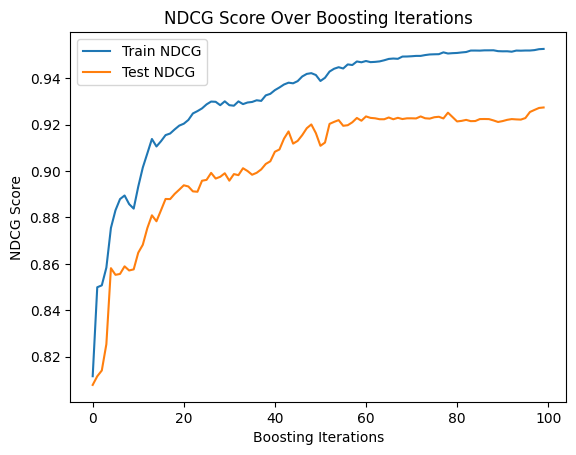

In [67]:
# Plot NDCG over iterations
import matplotlib.pyplot as plt

plt.plot(evals_result['train']['ndcg'], label="Train NDCG")
plt.plot(evals_result['test']['ndcg'], label="Test NDCG")
plt.xlabel("Boosting Iterations")
plt.ylabel("NDCG Score")
plt.title("NDCG Score Over Boosting Iterations")
plt.legend()
plt.show()

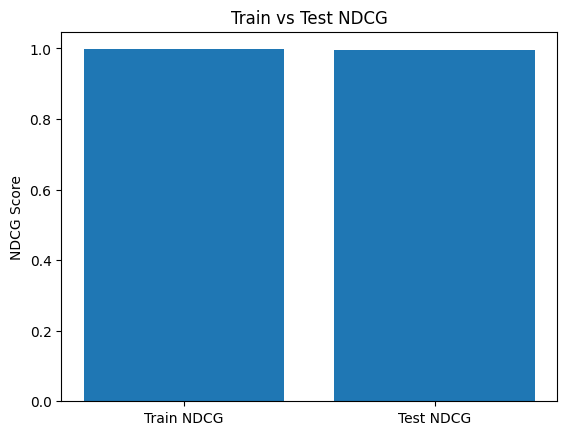

In [68]:
# Example: Comparing train and test NDCG scores
metrics = {"Train NDCG": train_ndcg, "Test NDCG": test_ndcg}

# Bar plot
plt.bar(metrics.keys(), metrics.values())
plt.ylabel("NDCG Score")
plt.title("Train vs Test NDCG")
plt.show()

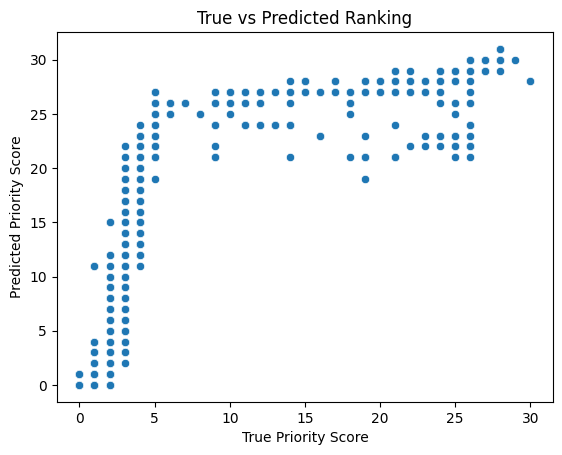

In [69]:
# Predicted vs True ranking (Test Set)
import seaborn as sns

results = pd.DataFrame({
    'True Score': y_test_scaled,
    'Predicted Score': test_predictions
})

sns.scatterplot(x='True Score', y='Predicted Score', data=results)
plt.title("True vs Predicted Ranking")
plt.xlabel("True Priority Score")
plt.ylabel("Predicted Priority Score")
plt.show()

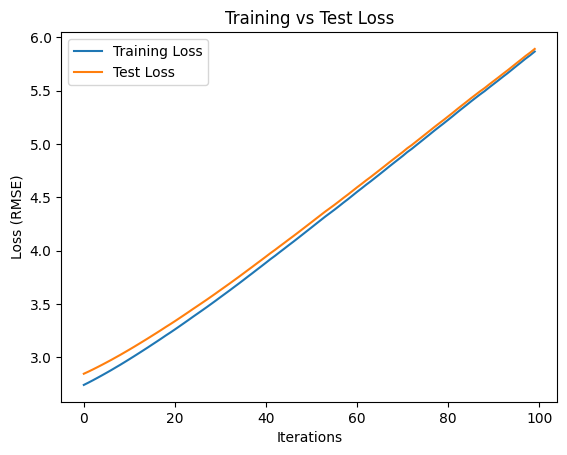

In [70]:
train_loss = evals_result['train']['rmse']
test_loss = evals_result['test']['rmse']

plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss (RMSE)")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

In [71]:
val_data = pd.read_csv("daan881_group4_dataset.val.csv")

features = [
    "attack_vector",
    "attack_complexity",
    "attack_requirements",
    "privileges_required",
    "user_interaction",
    "exploit_maturity",
    "epss",
    "percentile",
    "cvss_score",
    "cvss_severity",
    "days_since_published",
    "date_reserved_published_delta"
]
X = val_data[features]
y = val_data["priority_score"]
groups = val_data["group_id"]

# Verify group integrity
print("Val Groups:", groups.unique())

# Calculate group sizes for training and testing
val_group_sizes = groups.value_counts(sort=False).values

scaler = MinMaxScaler(feature_range=(0, 31))
y_val_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten().astype(int)

# Create DMatrix for XGBoost
val_dmatrix = xgb.DMatrix(X, label=y_val_scaled)

# Set group sizes
val_dmatrix.set_group(val_group_sizes)

val_predictions = ranker.predict(val_dmatrix)

val_ndcg = ndcg_score([y_val_scaled], [val_predictions])

print(f"Val NDCG: {val_ndcg}")

scaler = MinMaxScaler(feature_range=(0, 31))
val_predictions = scaler.fit_transform(val_predictions.reshape(-1, 1)).flatten().astype(int)

# Compute MRR for test set
test_mrr = mean_reciprocal_rank(y_val_scaled, val_predictions,val_group_sizes)
print(f"Val MRR: {test_mrr}")

Val Groups: [1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014
 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042
 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056
 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070
 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084
 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098
 1099 1100]
Val NDCG: 0.9966288131484933
Val MRR: 0.9604166666666667


# DEMO

Load the demo CSVs

In [72]:
demo_data = pd.read_csv("daan881_group4_dataset.demo.csv")

features = [
    "attack_vector",
    "attack_complexity",
    "attack_requirements",
    "privileges_required",
    "user_interaction",
    "exploit_maturity",
    "epss",
    "percentile",
    "cvss_score",
    "cvss_severity",
    "days_since_published",
    "date_reserved_published_delta"
]
X = xgb.DMatrix(demo_data[features])
val_predictions = ranker.predict(X)

scaler = MinMaxScaler(feature_range=(0, 31))
val_predictions = scaler.fit_transform(val_predictions.reshape(-1, 1)).flatten().astype(int)
val_predictions 

demo_data["priority_score"] = val_predictions

sorted_df = demo_data.sort_values(by="priority_score", ascending=False)

sorted_df.to_csv("daan881_group4_dataset.demo.sorted.csv")